# Case para *Data Science* Plannera

Neste *Jupyter Notebook* está a análise e tratamento dos dados cedidos como um *case* pela empresa Plannera. 

Fora as  bibliotecas padrões de *data science*, como pandas, numPy, scikit-learn e matplotlib, algumas bibliotecas extras foram utilizadas:

- seaborn, uma biblioteca para gerar gráficos. Para instalar, execute o comando 
> pip install seaborn

- scikit-lego, uma biblioteca que expande as funções da biblioteca scikit-learn. Para instalar, execute o comando
> pip install scikit-lego

Esse *notebook* importa suas funções de outros arquivos em Python. Para mais detalhes, dê uma olhada neles.

In [1]:
from geradorExcel import gerarExcel

from randomForest import gerarResultadoRandomForest, gerarResultadoZIRRandomForest
from linearRegression import gerarResultadoLinearRegression, gerarResultadoZIR_LR
from geradorGraficos import gerarGraficoMensal, gerarGraficoLinear, gerarGraficoMensalClusterEspecifico, gerarHistograma
from tratamentoDados import gerarDados, gerarMesTeste
from poisson import gerarResultadoPoisson, gerarResultadoZIRPoisson
from geradorMetricas import gerarMetricaGeral, gerarMetricasClusters

from sklearn.metrics import r2_score

import numpy as np

import matplotlib.pyplot as plt

<Figure size 576x432 with 0 Axes>

Os dados históricos são lidos e tratados. Os dados sem o *target* estão em x. O *target* está em y. Os detalhes do tratamento dos dados estão em tratamentoDados.py.

In [2]:
X, y = gerarDados()

Para checar como é o formato do *target* que é buscado, é necessário analisar como é distribuido o *target* de cada elemento do conjunto de dados.

In [3]:
print(y.describe())

count    3360.000000
mean      632.178274
std      1080.704647
min         0.000000
25%         1.000000
50%       317.000000
75%       678.000000
max      7810.000000
Name: Remessas, dtype: float64


Pelo fato de ter elementos com o *target* de valor 0, isso pode prejudicar os modelos regressores que serão utilizados. 

Assimetria: 3.242776156654992
Curtose: 10.797080703001154


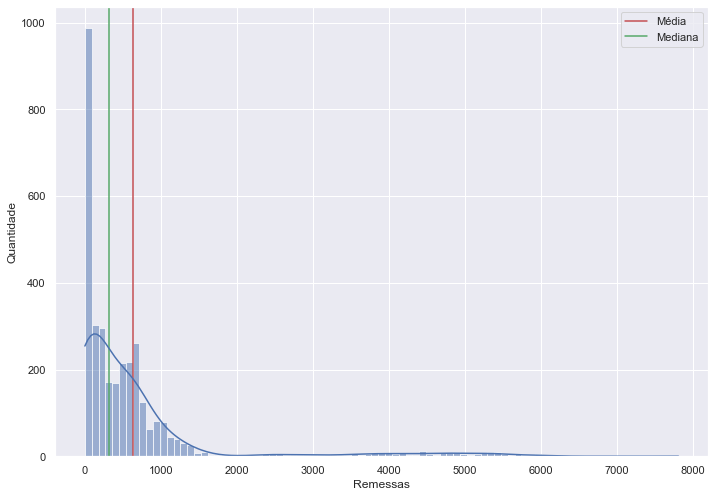

In [4]:
gerarHistograma(y)

Como o conjunto de dados não tem elementos negativos, a assimetria é positiva, indicando que existem mais elementos à direita do pico da função de distribuição. A curtose positiva indica uma curva leptocurtica, indicando que existem mais valores no *target* que fogem da média do que valores que convirjam [para a média].

### O problema: o modelo é inflado por zeros

Utilizando o histograma, é fácil de perceber que existem muitos valores 0 no *target*. Isso prejudicará os modelos na hora da predição. Quando um conjunto de dados tem uma grande quantidade de valores no *target* como 0, isso pode atrapalhar o treinamento de um modelo regressor. Esses problemas são chamados de *zero-inflated*, ou inflados por zeros.

Uma solução para esse tipo de distribuição no conjunto de dados: utilizar um modelo em duas partes, que será explicado futuramente.

### Outra maneira de ver o conjunto de dados

Outro jeito de visualizar o *target* é comparar o mesmo com outra *feature* que é diretamente proporcional ao mesmo: Volume. Cria-se, então, o gráfico "Remessas x Volume".

Text(0, 0.5, 'Remessas')

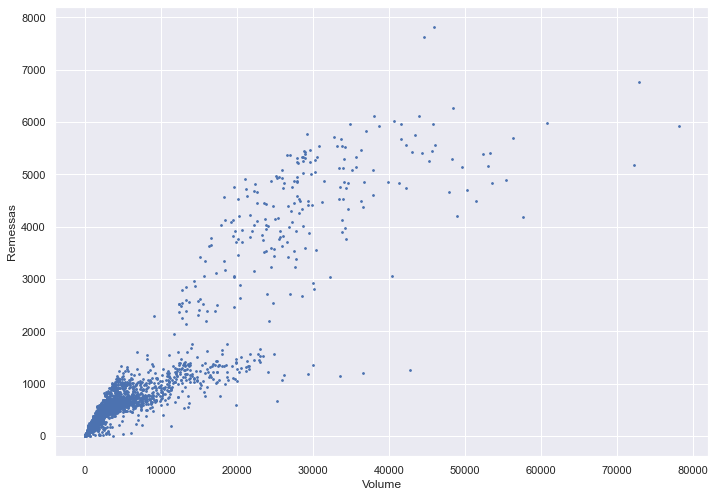

In [5]:
plt.clf()

plt.scatter(X['Volume'], y, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

Realmente a relação entre essas duas *features* é mais ou menos diretamente proporcional. Com essa informação, pode-se concluir que a predição de um mês será do mesmo modelo: na maioria das vezes, quanto maior a *feature* volume, maior o *target* Remessas.

## Separando os dados em treinamento e teste

Para ter uma métrica de cada modelo e o quão preciso é o mesmo, é utilizado o próprio conjunto de dados com o *target* que temos. É, então, selecionado um mês disponível no conjunto de dados para ser separado como teste. O resto dos meses serão utilizados para treinamento de cada modelo preditivo.

In [6]:
mes = 7
ano = 2020

Para fins de teste, foi escolhido o mês de Julho de 2020. Qualquer outro mês existente no conjunto de dados "Dados Históricos" pode ser escolhido. 

In [7]:
X_treino, X_val, y_treino, y_val = gerarMesTeste(X, y, mes, ano)

Text(0, 0.5, 'Remessas')

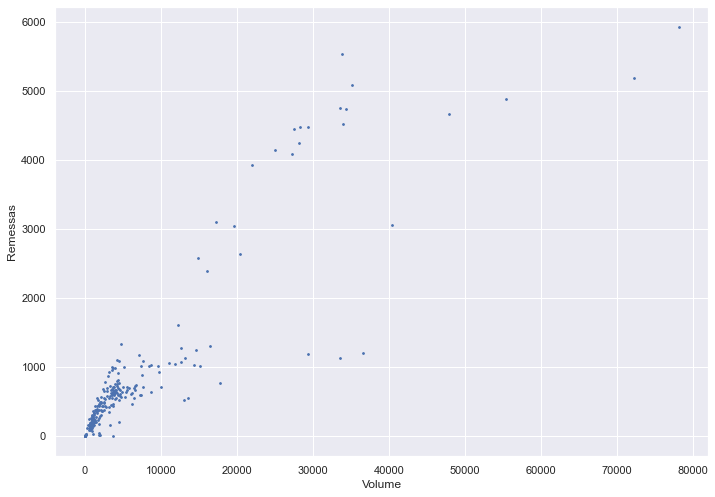

In [8]:
plt.clf()

plt.scatter(X_val['Volume'], y_val, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

## As métricas

### $R^2$ *Score*

Uma medida  que pode ser utilizada para avaliar o quão bom é um modelo de regressão é a medida $R^2$. Essa medida revela quanto a variação do resultado pode ser explicada em relação à *feature* escolhida para treinar o modelo. Um valor perfeito é 1, podendo atingir valores negativos (pois o modelo pode ser arbitrariamente ruim em prever valores após treinado). Quando o modelo tem $R^2$ = 0, ele está acertando todas as predições. Sua fórmula de implementação é dada a partir das seguintes fórmulas:

>$SQ_{tot} = \sum_{i = 1}^{n}({y}_{i} - \bar{y})^2 $,

representando a Soma Total dos Quadrados;

>$SQ_{res} = \sum_{i=1}^{n} (y_i - \hat{y}_{i})^2$,

representando a Soma dos Quadrados dos resíduos, erros que não são explicados pelo modelo, e;

>$SQ_{exp} = \sum_{i=1}^{n} (\hat{y}_{i} - \bar{y})^2$,

representando a Soma dos Quadrados explicada, indicando a diferença entre a média das observações, o valor estimado para cada observação e a soma dos respectivos quadrados. Quanto maior, mais explicativo é o modelo.

onde:

> $n$ representa a quantidade de elementos preditos e reais;

> $y_{i}$ representa o valor real;

> $\bar{y}$ representa a média dos valores reais.

> $\hat{y}_{i}$ representa o valor predito;

em alguns casos, pode-se ter:

>$SQ_{tot} = SQ_{exp} + SQ_{res}$

e, então, normalizando a função acima:

>$R^2 = \frac{SQ_{tot}}{SQ_{exp}} = 1 - \frac{SQ_{res}}{SQ_{tot}}$

### *Mean Absolute Error* (MAE)

O MAE (ou Erro Absoluto Médio) representa a média das distâncias entre valores preditos e reais. Seus valores variam entre 0 e infinto. Sua fórmula representativa é:

> MAE = $\frac{1}{n}\sum_{i=1}^{n} |\hat{y}_{i} - y_i|$,

onde:

> $n$ representa a quantidade de elementos preditos e reais;

> $\hat{y}_{i}$ representa o valor predito;

> $y_i$ representa o valor real.

Uma vantagem é que é uma métrica com interpretação bem intuitiva, além de muito sólida para modelos que preveem muitos dados, ou que os dados são de forma sazonal, como temperatura de uma região ou envio e recebimento de produtos mensais. Já uma desvantagem é que, para problemas mais delicados, não é uma métrica tão punitiva para predições erradas, já que não eleva o valor das distâncias ao quadrado.

### *Mean Squared Error* (MSE)

A métrica MSE (ou Erro Quadrático Médio) é uma métrica muito utilizada para interpretar resultados em predições. Assim como a métrica anterior, seus valores variam entre 0 e infinto. Sua implementação é dada pela seguinte fórmula:

> MSE = $\frac{1}{n}\sum_{i=1}^{n} (\hat{y}_{i} - y_i)^2$

Uma vantagem dessa métrica é predições muito distantes do valor real aumentam o valor da métrica, punindo modelos que cometem erros. Já uma desvantagem é a falta de interpretação direta do resultado da métrica, uma vez que a unidade de predição de valores é $u$, a unidade de medida de MSE é $u^2$.

### *Root Mean Squared Error* (RMSE)

Esta métrica, também conhecida como Raiz do erro quadrático médio, visa melhorar os pontos negativos da métrica anterior, acertando a unidade de predição com a unidade de medida da métrica, ainda mantendo a ideia punitiva para os modelos. Como a MAE e MSE, os valores variam entre 0 e infitino. Sua fórmula é a seguinte:

> RMSE = $\sqrt{ \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_{i} - y_i)^2 }$

Após essa explicação, é criada uma lista onde será armazenado o valor de cada valor da métrica $R^2$ dos modelos na fase de validação.

A escolha de utilizar essa métrica como avaliativa foi pela mesma ser de fácil interpretação e ser suficientemente completa para avaliar o desempenho dos modelos.

In [9]:
r2_val_metrics = []

## Os modelos

### *Random Forest* convencional

Um dos modelos escolhidos para esse *case* foi o *Random Forest*. O *Random Forest* é um modelo pretidivo do tipo *ensemble*, ou seja, é um conjunto de outros modelos preditivos, nesse caso, a árvore de decisão. Esse modelo pode ser usado tanto para problemas de classificação quanto para regressão. Esse modelo preditor consegue lidar bem com *targets* com um excesso de valores 0, então foi uma opção na hora de escolher um modelo para o *case*.

In [10]:
resultadoRF = gerarResultadoRandomForest(X_treino, X_val, y_treino)

Após a criação do modelo *Random Forest* e seu treinamento, o resultado é calculado. Após isso, é comparado o mesmo com o valor real do mês, dado que temos esse valor no conjunto de dados.

Text(0, 0.5, 'Remessas previstas')

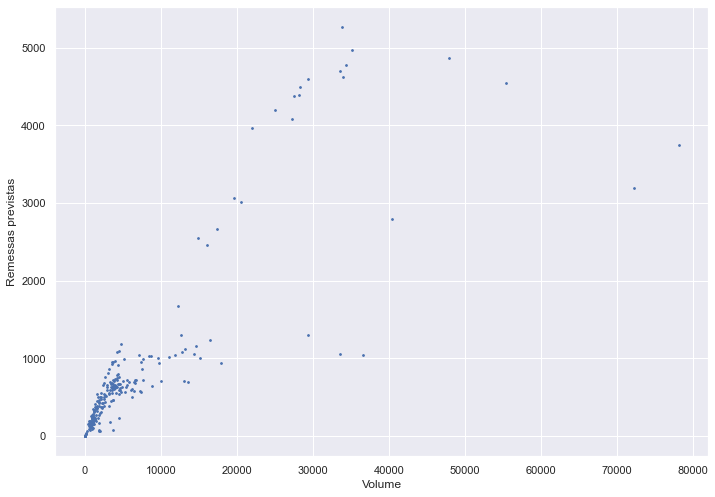

In [11]:
plt.clf()

plt.scatter(X_val['Volume'], resultadoRF, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas previstas")

Assimetria: 2.992169782932218
Curtose: 8.75305148925008


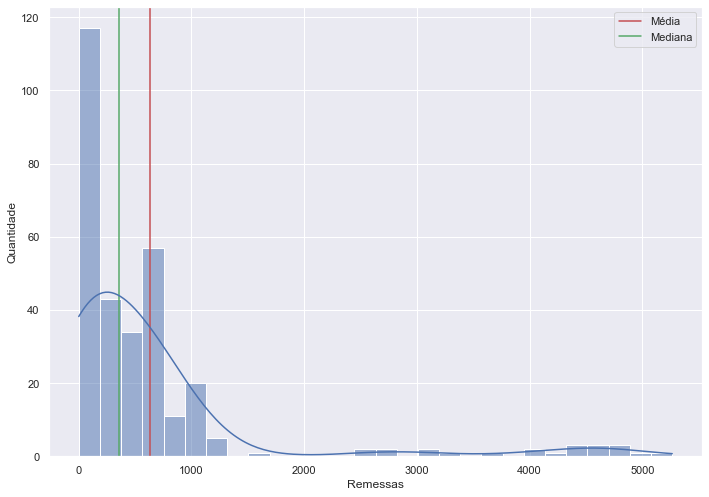

In [12]:
gerarHistograma(resultadoRF)

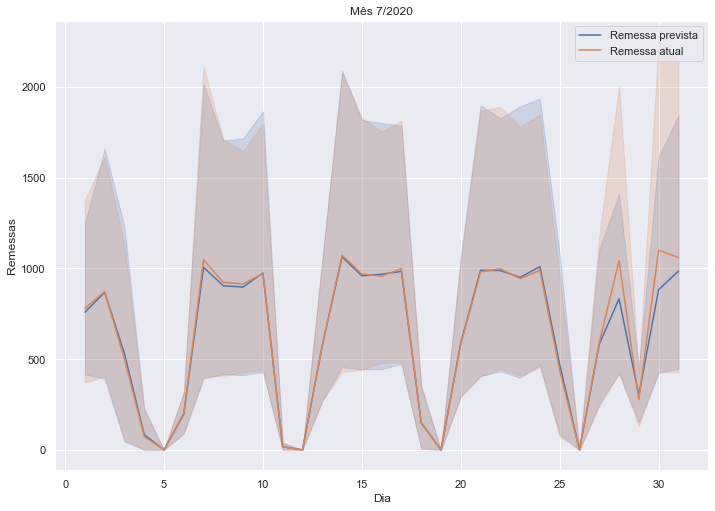

In [13]:
gerarGraficoMensal(X_treino, X_val, y_val, resultadoRF, comecoMes = 0)

As linhas representam os valores médios de cada *Cluster*. As áreas em volta das linhas são os valores reais e sua flutuação. As linhas e as áreas estão bem próximas uma das outras, indicando que o modelo criado parece estar bom. Mas, o quão bom está?

In [14]:
r2RF = r2_score(y_val, resultadoRF)

r2_val_metrics.append(r2RF)

print('R^2 Score: {}'.format(r2RF))

R^2 Score: 0.9725562587571184


In [15]:
gerarMetricaGeral(y_val, resultadoRF)

Mean Squared Error: 31228.860631290318
Root Mean Squared Error: 176.71689401777726
Mean Absolute Error: 35.272161290322586



Dado que cada métrica pode variar de 0 até o infinito, parece que os resultados não são os melhores, apesar do gráfico nos mostrar que o resultado está bem próximo do valor original. Que tal ver os gráficos e as medidas isoladas de cada *Cluster*? Talvez um ou mais sejam um *outlier*, ou seja, algo fora do padrão, que pode ir contra ao que o modelo aprendeu. 

<Figure size 842.4x595.44 with 0 Axes>

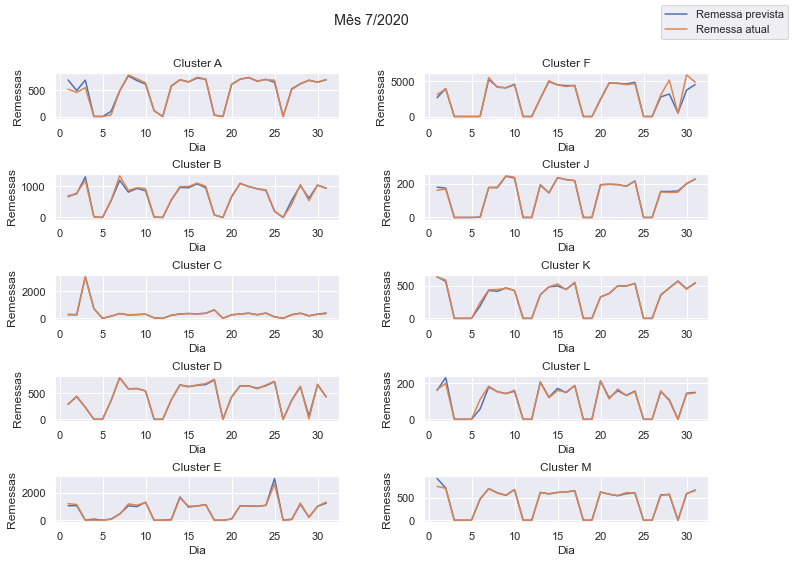

In [16]:
gerarGraficoMensalClusterEspecifico(X_treino, X_val, y_val, resultadoRF, comecoMes = 0)

Só pelo gráfico, dá para ver que o modelo é até bem preciso no maior dos casos. Os *Clusters* que tem mais diferença entre o valor real e o predito são o B e o F. 

In [17]:
gerarMetricasClusters(X_val, y_val, resultadoRF)

No Cluster A
Mean Squared Error: 2017.0377290322579
Root Mean Squared Error: 44.91144318581021
Mean Absolute Error: 20.616129032258062

No Cluster B
Mean Squared Error: 2392.18665483871
Root Mean Squared Error: 48.90998522631867
Mean Absolute Error: 30.844193548387103

No Cluster C
Mean Squared Error: 193.04360967741914
Root Mean Squared Error: 13.894013447431924
Mean Absolute Error: 9.114516129032253

No Cluster D
Mean Squared Error: 140.3634322580645
Root Mean Squared Error: 11.847507428065386
Mean Absolute Error: 6.3264516129032256

No Cluster E
Mean Squared Error: 7758.476645161291
Root Mean Squared Error: 88.08221526029696
Mean Absolute Error: 47.30516129032258

No Cluster F
Mean Squared Error: 298393.6501483871
Root Mean Squared Error: 546.2541992043513
Mean Absolute Error: 214.42258064516133

No Cluster J
Mean Squared Error: 18.139519354838686
Root Mean Squared Error: 4.259051461867852
Mean Absolute Error: 2.2712903225806436

No Cluster K
Mean Squared Error: 176.73558064516124
R

Utilizando as métricas, é confirmado as suspeitas: enquanto a média do erro absoluto varia entre 2 e 30 nos outros *Clusters*, o B e o F têm a média de erro absoluto de 44 e 214, respectivamente.

O resultado será salvo como um arquivo em Excel.

In [18]:
gerarExcel(resultadoRF, X_val, mes = mes, ano = ano, nome = 'RandomForest', train = True)

### *Random Forest* como um regressor inflado por zeros (*Zero-Inflated Regressor*)

Para resolver o problema do *target* ser inflado por zeros e possivelmente melhorar os resultados do *Random Forest*, a biblioteca scikit-lego tem a implementação de um *Zero-Inflated Regressor*, ou ZIR. 

A grande diferença desse modelo para o *Random Forest* convencional é que, durante o treino, este roda um classificador para treinar qual valor no *target* é 0 e qual não é. Após isso, os valores que são diferentes de 0 são utilizados para treinar outro modelo, dessa vez, um regressor. Como o *Random Forest* funciona para ambos os problemas, o ZIR utilizado nesse conjunto de dados utilizará o *Random Forest* tanto para a parte de classificação quanto para a parte de regressão.

In [19]:
resultado_ZIR_RF = gerarResultadoZIRRandomForest(X_treino, X_val, y_treino)

Text(0, 0.5, 'Remessas')

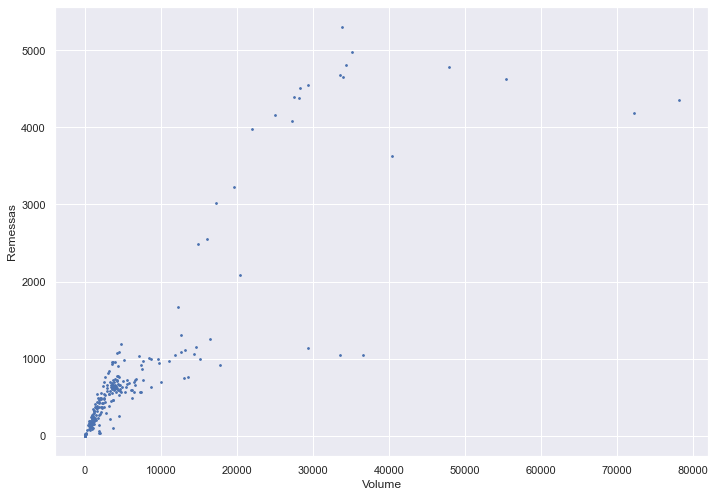

In [20]:
plt.clf()

plt.scatter(X_val['Volume'], resultado_ZIR_RF, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

Assimetria: 2.988581848790257
Curtose: 8.555404935030817


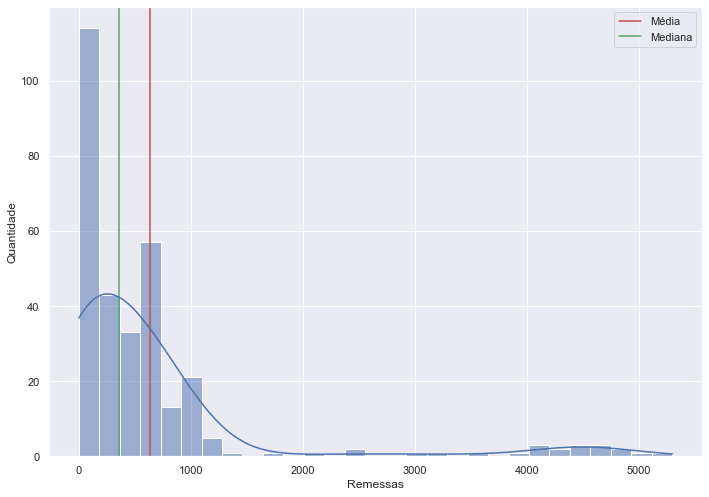

In [21]:
gerarHistograma(resultado_ZIR_RF)

Então, o gráfico é gerado com o resultado.

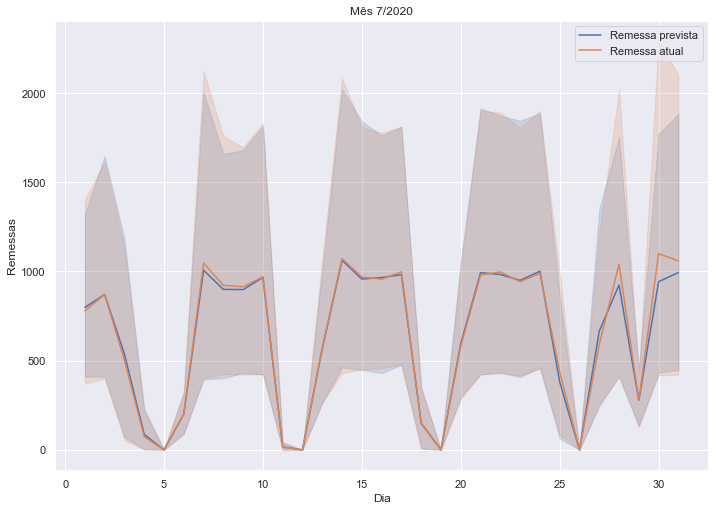

In [22]:
gerarGraficoMensal(X_treino, X_val, y_val, resultado_ZIR_RF, comecoMes = 0)

Como antes, será exibido as suas métricas avaliativas.

In [23]:
gerarMetricaGeral(y_val, resultado_ZIR_RF)

Mean Squared Error: 15106.62508258065
Root Mean Squared Error: 122.9090113969706
Mean Absolute Error: 31.659225806451616



Os resultados das métricas são melhores que o *Random Forest* convencional. Após isso, tem o gráfico comparativo de cada *Cluster* e suas métricas.

<Figure size 842.4x595.44 with 0 Axes>

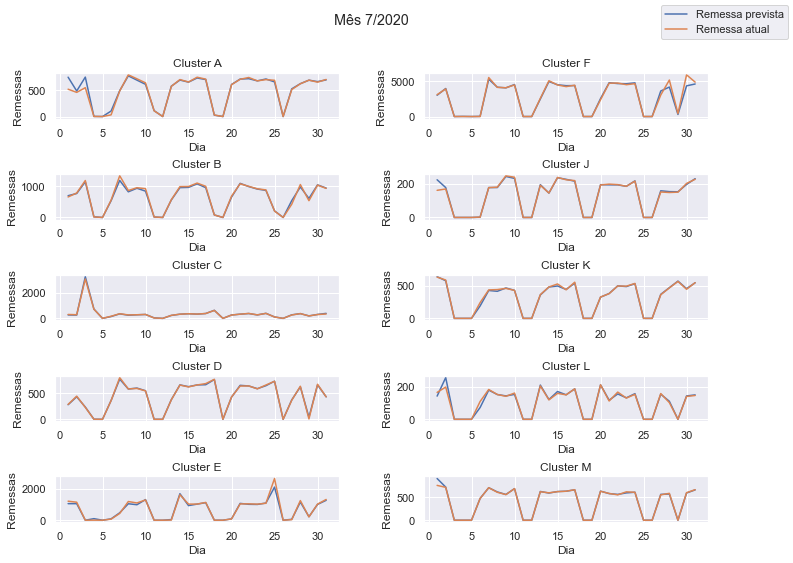

In [24]:
gerarGraficoMensalClusterEspecifico(X_treino, X_val, y_val, resultado_ZIR_RF, comecoMes = 0)

Como antes, os *Clusters* B e F apresentam a maior diferença entre predição e valor real. Mas, os *Clusters* individuais tiveram melhora em relação ao *Random Forest* convencional?

In [ ]:
r2_ZIR_RF = r2_score(y_val, resultado_ZIR_RF)

r2_val_metrics.append(r2_ZIR_RF)

print('R^2 Score: {}'.format(r2_ZIR_RF))

R^2 Score: 0.990225207132753


In [ ]:
gerarMetricasClusters(X_val, y_val, resultado_ZIR_RF)

No Cluster A
Mean Squared Error: 2636.9731645161282
Root Mean Squared Error: 51.351467014255086
Mean Absolute Error: 22.977096774193555

No Cluster B
Mean Squared Error: 2309.3918193548366
Root Mean Squared Error: 48.056131964139986
Mean Absolute Error: 31.22838709677419

No Cluster C
Mean Squared Error: 731.9409935483864
Root Mean Squared Error: 27.05440802435689
Mean Absolute Error: 12.826451612903224

No Cluster D
Mean Squared Error: 76.85310645161292
Root Mean Squared Error: 8.766590354956305
Mean Absolute Error: 5.928709677419355

No Cluster E
Mean Squared Error: 12888.985890322583
Root Mean Squared Error: 113.52966964772946
Mean Absolute Error: 50.92709677419355

No Cluster F
Mean Squared Error: 91172.18616129032
Root Mean Squared Error: 301.94732348754195
Mean Absolute Error: 144.0567741935484

No Cluster J
Mean Squared Error: 103.17349032258065
Root Mean Squared Error: 10.157435223646797
Mean Absolute Error: 3.7406451612903235

No Cluster K
Mean Squared Error: 187.7975580645162

A melhora não foi muito significativa, mas foi, mesmo assim, uma melhora.

De novo, os valores foram salvos em um arquivo Excel.

In [ ]:
gerarExcel(resultado_ZIR_RF, X_val, mes = mes, ano = ano, nome = 'ZIR_RandomForest', train = True)

### Regressão linear padrão

A Regressão Linear é um algoritmo que treina a partir de *feature*(s) do conjunto de dados e traça uma linha no gráfico que representa a correlação entre a(s) *feature*(s) e o *target*. A linha é formada a partir desta fórmula:

> y = $\theta$ * x + b

sendo:

- $\theta$ o peso da *feature*, que representa o impacto que a mesma tem quando treinando o modelo.

- b o interceptor, ou, o termo de viés, que representa a tendência do resultado da regressão de se deslocar de maneira consistente, a partir da origem, quando perto de unidades b.

In [ ]:
resultadoLR = gerarResultadoLinearRegression(X_treino, X_val, y_treino)

Features utilizadas: ['Volume']


Após criar e treinar o modelo de regressão linear, é gerado o resultado em um gráfico. 

Text(0, 0.5, 'Remessas')

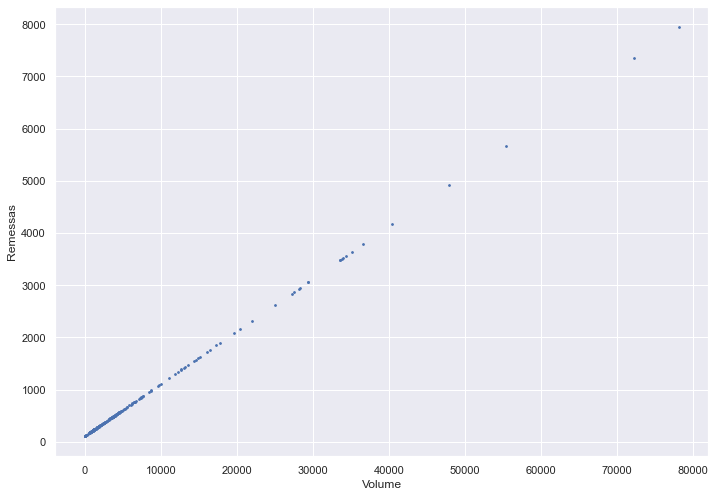

In [ ]:
plt.clf()

plt.scatter(X_val['Volume'], resultadoLR, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

Assimetria: 3.8943909692482825
Curtose: 18.724958845254733


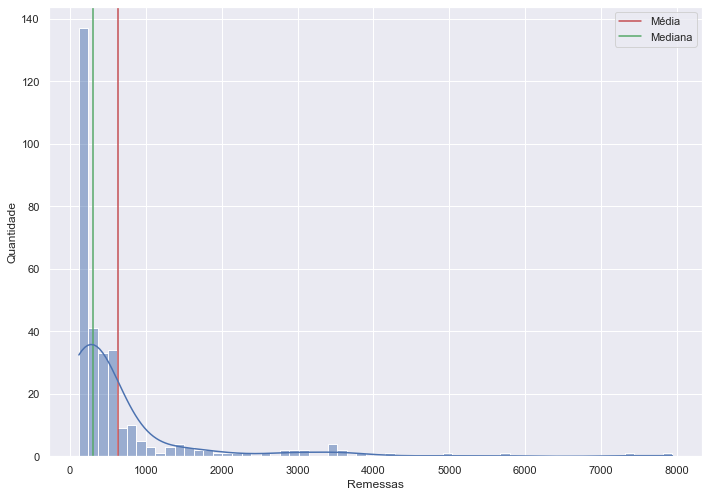

In [ ]:
gerarHistograma(resultadoLR)

Como esperado, o resultado da regressão linear gerou pontos muito mais ordenados que as versões de *Random Forest*.

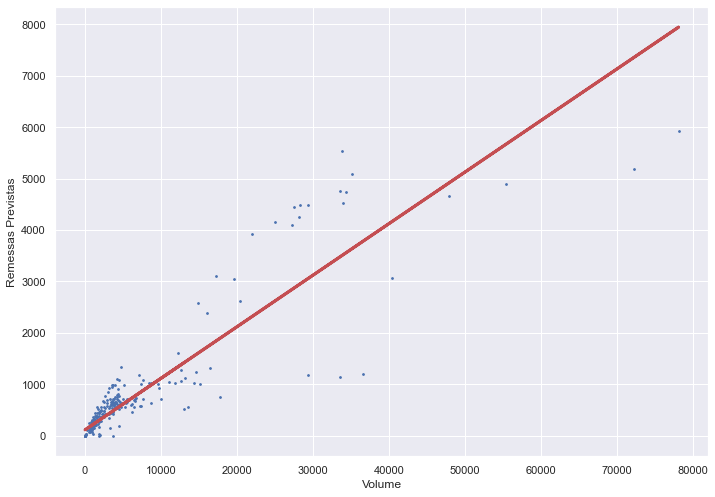

In [ ]:
gerarGraficoLinear(X_val, y_val, resultadoLR)

E esse é o gráfico que foi gerado, comparando o valor real do *target* com a linha gerada a partir da Regressão Linear.

Comparando esse gráfico e o resultado com os gráficos e os resultados, A regressão linear não parece ser melhor que os modelos já vistos.

O gráfico que representa a previsão do mês feita pelo modelo e as medidas avaliativas da previsão são exibidos a seguir.

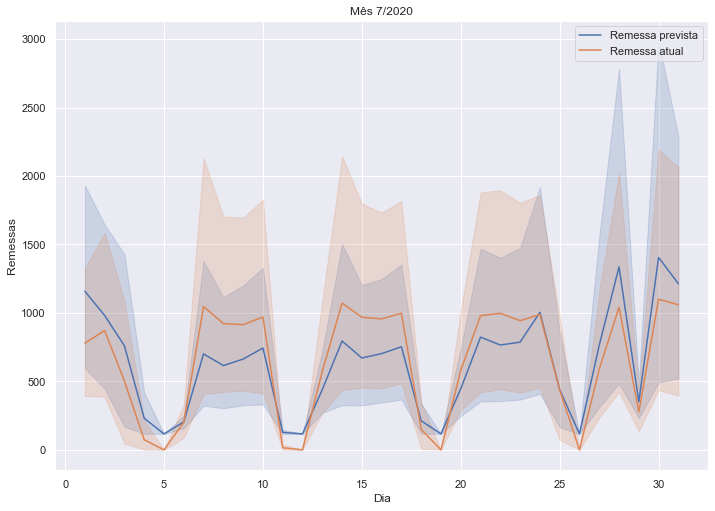

In [ ]:
gerarGraficoMensal(X_treino, X_val, y_val, resultadoLR, comecoMes = 0)

In [ ]:
gerarMetricaGeral(y_val, resultadoLR)

Mean Squared Error: 219000.16959123372
Root Mean Squared Error: 467.97453946901186
Mean Absolute Error: 244.49718954954784



In [ ]:
r2LR1 = r2_score(y_val, resultadoLR)

print('R^2 Score: {}'.format(r2LR1))

r2_val_metrics.append(r2LR1)

R^2 Score: 0.8075439236362345


<Figure size 842.4x595.44 with 0 Axes>

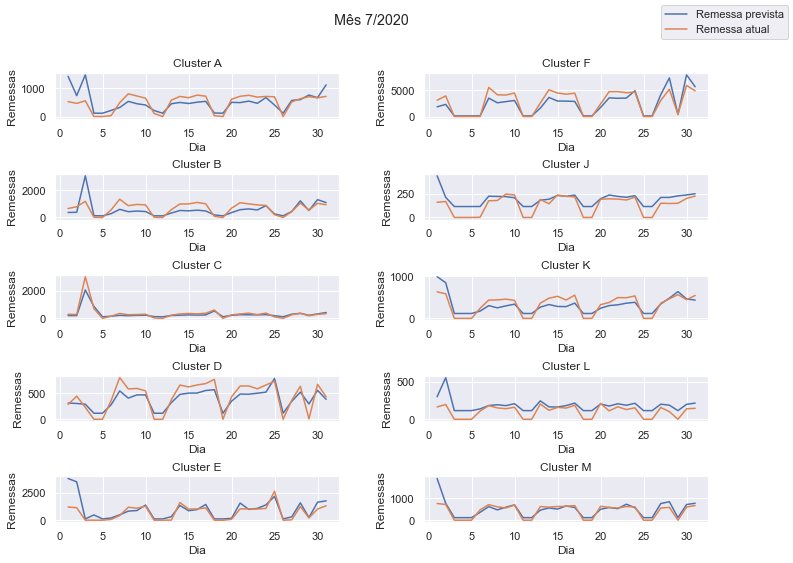

In [ ]:
gerarGraficoMensalClusterEspecifico(X_treino, X_val, y_val, resultadoLR, comecoMes = 0)

In [ ]:
gerarMetricasClusters(X_val, y_val, resultadoLR)

No Cluster A
Mean Squared Error: 86373.78975700127
Root Mean Squared Error: 293.89418122344864
Mean Absolute Error: 213.48425062276362

No Cluster B
Mean Squared Error: 227225.43850285807
Root Mean Squared Error: 476.68169516235685
Mean Absolute Error: 334.97473977480314

No Cluster C
Mean Squared Error: 38106.97790134012
Root Mean Squared Error: 195.21008657684706
Mean Absolute Error: 107.5559737427455

No Cluster D
Mean Squared Error: 18049.91745823374
Root Mean Squared Error: 134.3499812364473
Mean Absolute Error: 120.81545693107599

No Cluster E
Mean Squared Error: 463900.0975475341
Root Mean Squared Error: 681.1021197643817
Mean Absolute Error: 367.34892065281093

No Cluster F
Mean Squared Error: 1261796.9403377732
Root Mean Squared Error: 1123.2973517006853
Mean Absolute Error: 890.3506819085001

No Cluster J
Mean Squared Error: 7918.499689777169
Root Mean Squared Error: 88.98595220470008
Mean Absolute Error: 67.83368896328548

No Cluster K
Mean Squared Error: 21452.01859304037
R

Como esperado, a Regressão Linear tem uma média de erro muito maior que os modelos baseados em *Random Forest*. 

Um jeito de aprimorar a Regressão Linear é utilizar mais do que uma *feature* para treinar o modelo. 

In [ ]:
resultadoLR = gerarResultadoLinearRegression(X_treino, X_val, y_treino, n = 8)

Features utilizadas: ['Volume', 'Dropsize', 'Dia', 'Mês', 'Ano', 'é_dia_normal', 'é_feriado', 'é_fim_de_semana']


Assimetria: 3.8359799619718977
Curtose: 18.291639227469968


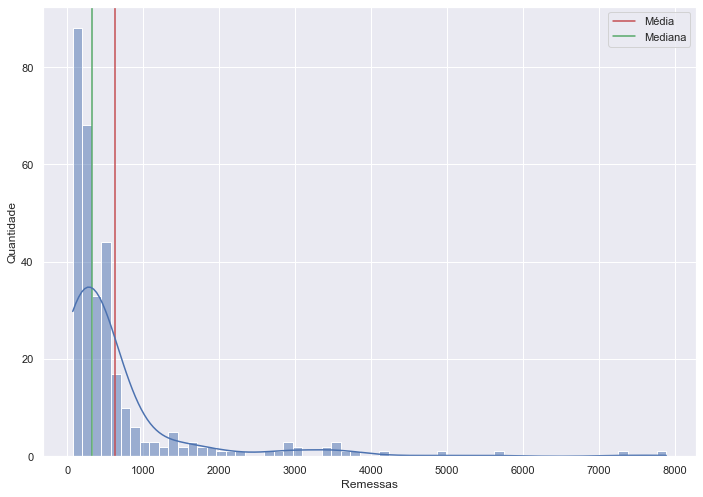

In [ ]:
gerarHistograma(resultadoLR)

Text(0, 0.5, 'Remessas')

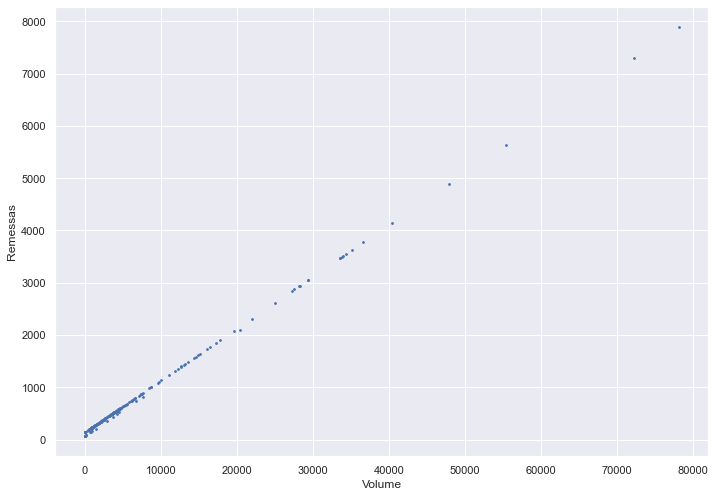

In [ ]:
plt.clf()

plt.scatter(X_val['Volume'], resultadoLR, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

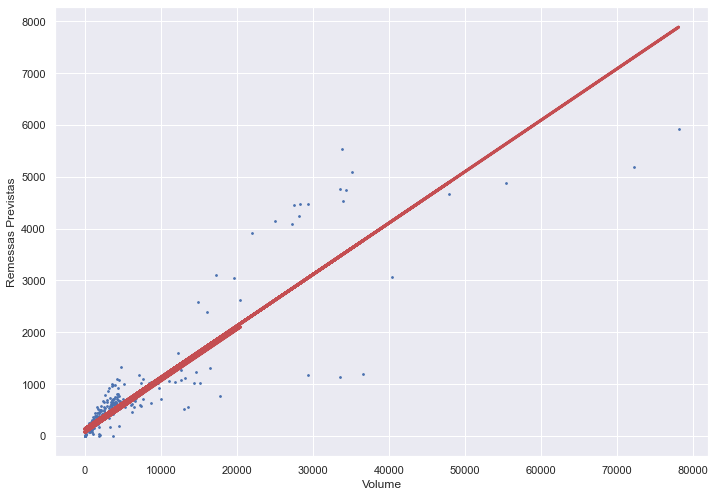

In [ ]:
gerarGraficoLinear(X_val, y_val, resultadoLR)

A linha que intercepta os pontos passa a ser uma função mais complexa que somente uma função de 1º grau. Porém, a complexidade torna ela mais próxima do que os valores reais são, melhorando, assim, a predição do modelo.

In [ ]:
gerarMetricaGeral(y_val, resultadoLR)

Mean Squared Error: 215032.05088251588
Root Mean Squared Error: 463.71548484228543
Mean Absolute Error: 232.85689602386063



In [ ]:
r2LR8 = r2_score(y_val, resultadoLR)

print('R^2 Score: {}'.format(r2LR8))

r2_val_metrics.append(r2LR8)

R^2 Score: 0.8110310832975759


Como o modelo se comportará, então, se usarmos todas as *features*?

In [ ]:
resultadoLR = gerarResultadoLinearRegression(X_treino, X_val, y_treino, n = 18)

Features utilizadas: ['Volume', 'Dropsize', 'Dia', 'Mês', 'Ano', 'é_dia_normal', 'é_feriado', 'é_fim_de_semana', 'Cluster_A', 'Cluster_B', 'Cluster_C', 'Cluster_D', 'Cluster_E', 'Cluster_F', 'Cluster_J', 'Cluster_K', 'Cluster_L', 'Cluster_M']


Text(0, 0.5, 'Remessas')

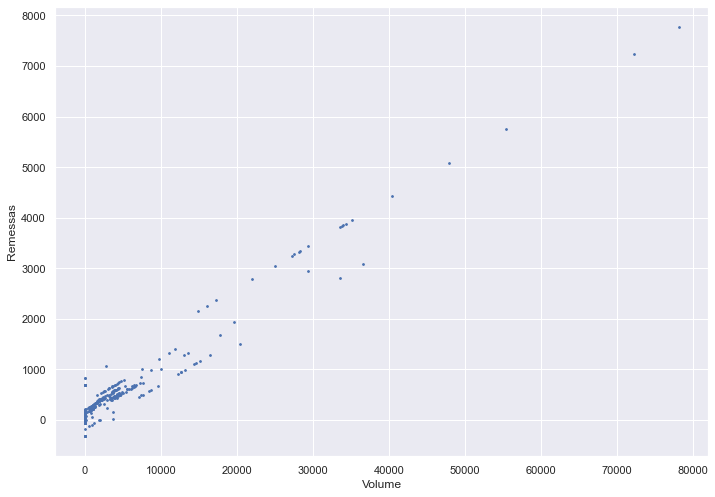

In [ ]:
plt.clf()

plt.scatter(X_val['Volume'], resultadoLR, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

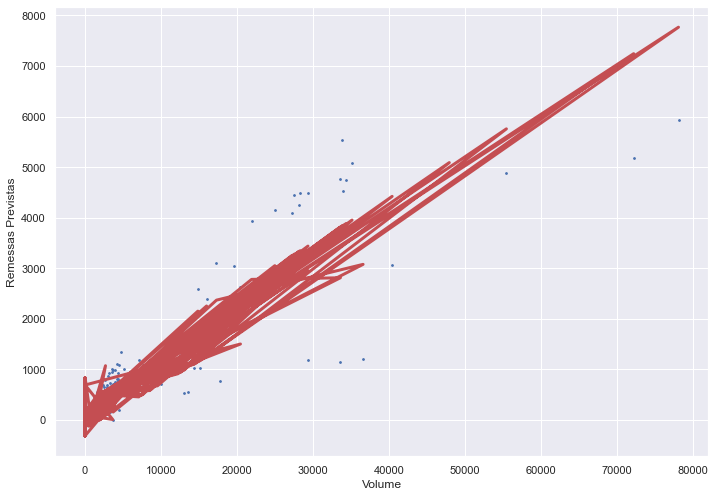

In [ ]:
gerarGraficoLinear(X_val, y_val, resultadoLR)

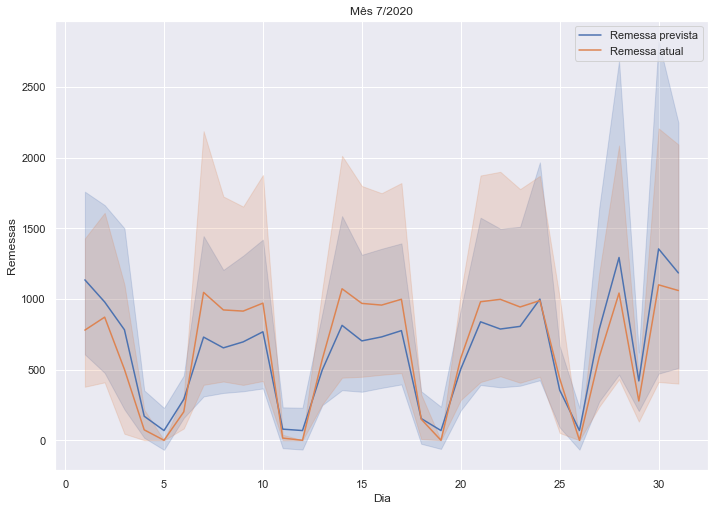

In [ ]:
gerarGraficoMensal(X_treino, X_val, y_val, resultadoLR, comecoMes = 0)

<Figure size 842.4x595.44 with 0 Axes>

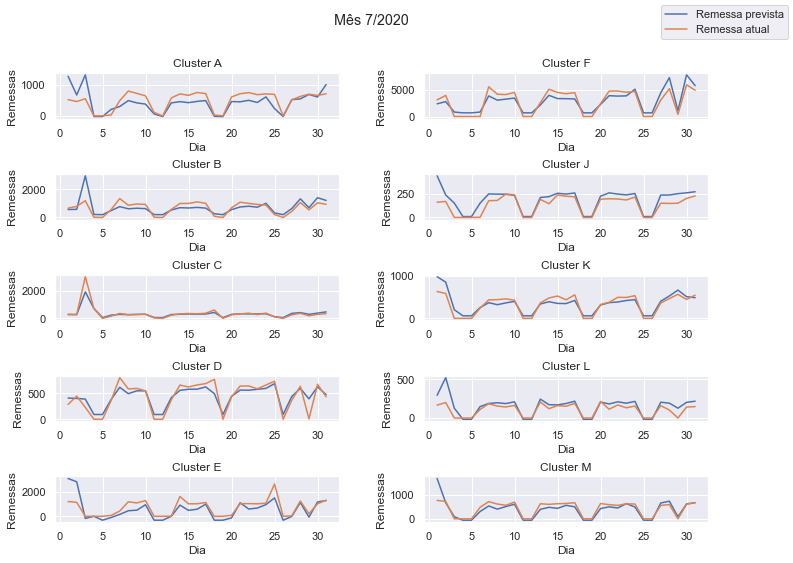

In [ ]:
gerarGraficoMensalClusterEspecifico(X_treino, X_val, y_val, resultadoLR, comecoMes = 0)

Parece um pouco melhor em relação a antes, mas não muito promissor... A seguir, as métricas:

In [ ]:
r2LR18 = r2_score(y_val, resultadoLR)

r2_val_metrics.append(r2LR18)

print('R^2 Score: {}'.format(r2LR18))

R^2 Score: 0.8501569010337553


In [ ]:
gerarMetricaGeral(y_val, resultadoLR)

Mean Squared Error: 170509.88831164778
Root Mean Squared Error: 412.9284300113614
Mean Absolute Error: 229.11899907033398



In [ ]:
gerarMetricasClusters(X_val, y_val, resultadoLR)

No Cluster A
Mean Squared Error: 75623.276875571
Root Mean Squared Error: 274.99686702864636
Mean Absolute Error: 200.88580803111302

No Cluster B
Mean Squared Error: 162558.42593603276
Root Mean Squared Error: 403.1853493568842
Mean Absolute Error: 279.2093491576576

No Cluster C
Mean Squared Error: 43961.12966144833
Root Mean Squared Error: 209.66909562796403
Mean Absolute Error: 85.13728193133797

No Cluster D
Mean Squared Error: 13522.87060282114
Root Mean Squared Error: 116.28787814222572
Mean Absolute Error: 87.34828769827654

No Cluster E
Mean Squared Error: 348513.6108676
Root Mean Squared Error: 590.3504136253315
Mean Absolute Error: 402.65271577406

No Cluster F
Mean Squared Error: 995552.129284832
Root Mean Squared Error: 997.7735861831742
Mean Absolute Error: 914.2682948007331

No Cluster J
Mean Squared Error: 6200.619284436516
Root Mean Squared Error: 78.74401110202932
Mean Absolute Error: 54.01401669214215

No Cluster K
Mean Squared Error: 13058.38529678445
Root Mean Squa

Um resultado mais parecido com os obtidos pelo *Random Forest* e sua versão ZIR.

In [ ]:
gerarExcel(resultadoLR, X_val, mes = mes, ano = ano, nome = 'LinearRegression', train = True)

### Regressão Linear com *Zero-Inflated Regressor*

Como visto anteriormente, a Regressão Linear não teve um resultado bom com o conjunto de dados. O motivo: os valores 0 atrapalha a predição do modelo, resultado em valores negativos (coisa que não deveria existir em uma expectativa de quantidade de remessas de produtos) quando deveria ser 0, e, quando não é 0, os valores gerados não são os mais precisos. 

Para resolver isso, é utilizado um modelo inflado por zero, similar ao que foi utilizado com o modelo de *Random Forest*: um classificador (nesse caso, o *Random Forest*) para prever quando o valor é 0 e quando não é, e um regressor (a Regressão Linear) para predizer os valores.

In [ ]:
resultado_ZIR_LR = gerarResultadoZIR_LR(X_treino, X_val, y_treino)

Features utilizadas: ['Volume']


Text(0, 0.5, 'Remessas')

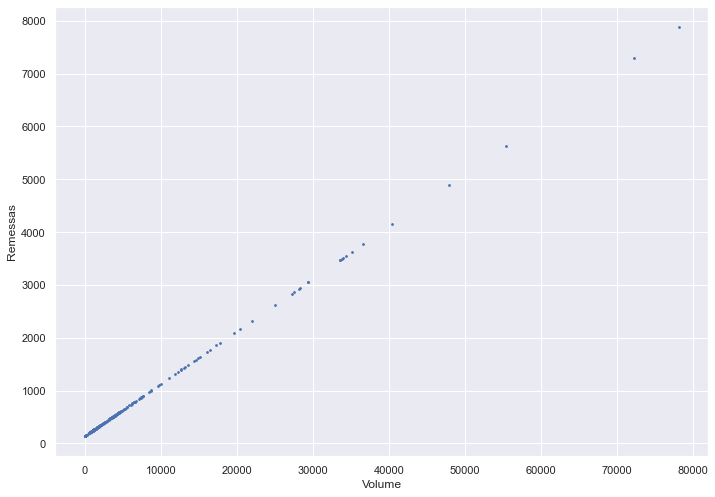

In [ ]:
plt.clf()

plt.scatter(X_val['Volume'], resultado_ZIR_LR, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

Como esperado, os valores formam uma linha reta no gráfico "Volume x Remessas".

Assimetria: 3.8943909692482817
Curtose: 18.72495884525472


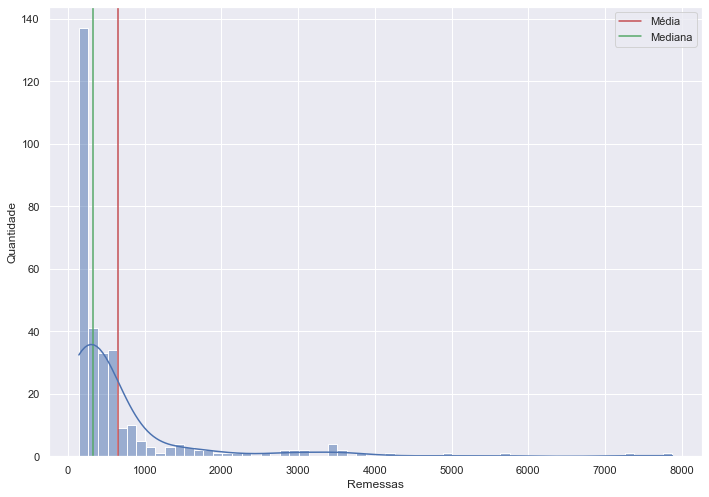

In [ ]:
gerarHistograma(resultado_ZIR_LR)

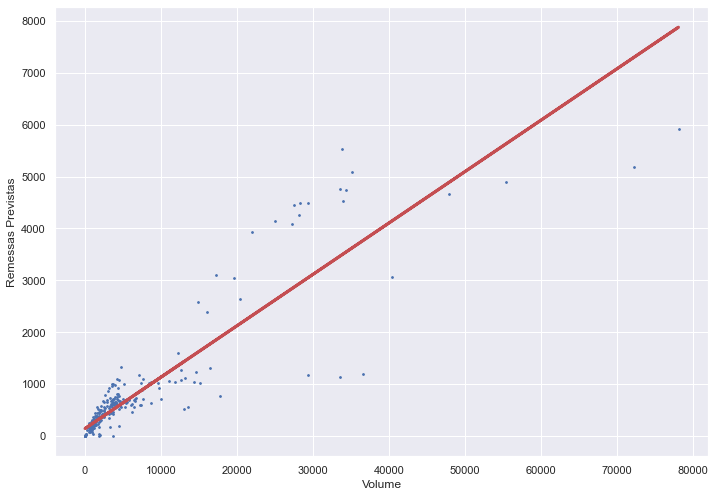

In [ ]:
gerarGraficoLinear(X_val, y_val, resultado_ZIR_LR)

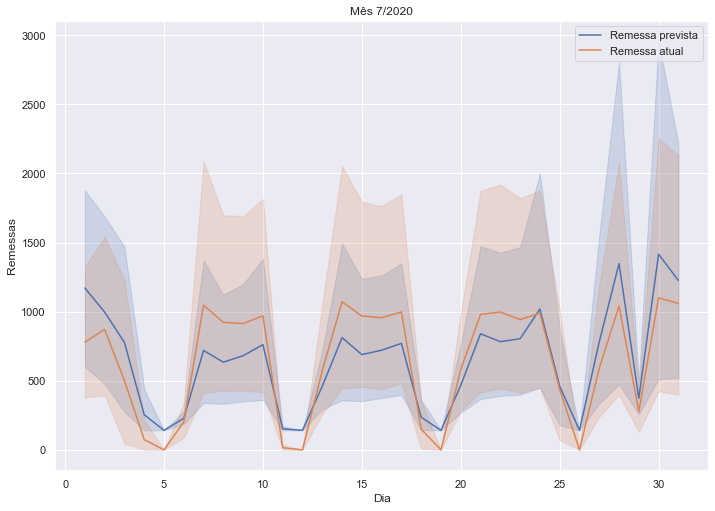

In [ ]:
gerarGraficoMensal(X_treino, X_val, y_val, resultado_ZIR_LR, comecoMes = 0)

In [ ]:
r2_ZIR_LR = r2_score(y_val, resultado_ZIR_LR)

r2_val_metrics.append(r2_ZIR_LR)

print('R^2 Score: {}'.format(r2_ZIR_LR))

R^2 Score: 0.8083837949084507


In [ ]:
gerarMetricaGeral(y_val, resultado_ZIR_LR)

Mean Squared Error: 218044.4608678443
Root Mean Squared Error: 466.9523111280683
Mean Absolute Error: 249.17131890328545



<Figure size 842.4x595.44 with 0 Axes>

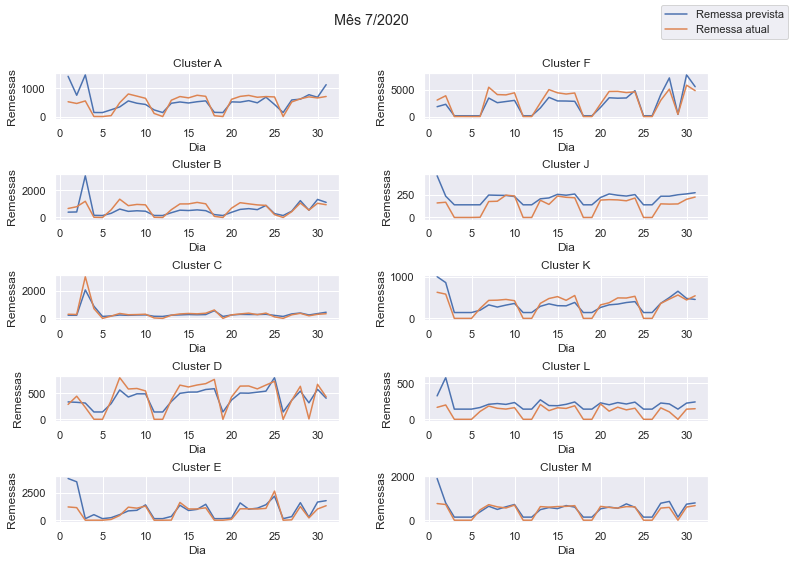

In [ ]:
gerarGraficoMensalClusterEspecifico(X_treino, X_val, y_val, resultado_ZIR_LR, comecoMes = 0)

In [ ]:
gerarMetricasClusters(X_val, y_val, resultado_ZIR_LR)

No Cluster A
Mean Squared Error: 86227.10853339155
Root Mean Squared Error: 293.644527504586
Mean Absolute Error: 212.6311718848345

No Cluster B
Mean Squared Error: 219138.56243795744
Root Mean Squared Error: 468.1223797661862
Mean Absolute Error: 330.9474660026151

No Cluster C
Mean Squared Error: 37882.11113262221
Root Mean Squared Error: 194.63327344681383
Mean Absolute Error: 104.56496822471335

No Cluster D
Mean Squared Error: 16747.741289087782
Root Mean Squared Error: 129.4130645997064
Mean Absolute Error: 114.1816405691141

No Cluster E
Mean Squared Error: 463455.08302087936
Root Mean Squared Error: 680.7753542989635
Mean Absolute Error: 376.6309032348841

No Cluster F
Mean Squared Error: 1252357.260700716
Root Mean Squared Error: 1119.0876912470783
Mean Absolute Error: 893.6396443097682

No Cluster J
Mean Squared Error: 11520.254269268029
Root Mean Squared Error: 107.33244742047033
Mean Absolute Error: 87.87146824865692

No Cluster K
Mean Squared Error: 21182.12262547525
Root

### Distribuição de Poisson

Na estatística, a distribuição de Poisson descreve resultados de experiências nos quais contamos acontecimentos que ocorrem aleatoriamente mas a uma taxa média definida. Essa distribuição pode ser utilizada para prever diversos acontecimentos: nascimento de bebês por mês em um hospital, o decaimento radioativo de um elemento químico, ou até gols de certo time em um jogo. A fórmula probabilística que representa a distribuição dos valores de um determinado evento é:

> P(X = x) = $\frac{\lambda^{k} * e^{\lambda} } {k!}$

Onde:

- $\lambda$ representa um número real correspondente ao número de ocorrências de um valor em um determinado intervalo de tempo;
- k representa a quantidade de vezes que um evento ocorre em um intervalo de tempo;
- e é o número de Euler.

Com essa fórmula e com o conjunto de dados, é possível treinar um modelo para prever, em um período de tempo, um valor para cada *cluster*, a cada dia. 

In [ ]:
resultadoPoisson = gerarResultadoPoisson(X_treino, X_val, y_treino)

Após o treinamento, gera-se um gráfico do estilo "Volume x Remessas", a *feature* e o *target* ediretamente proporcionais.

Text(0, 0.5, 'Remessas')

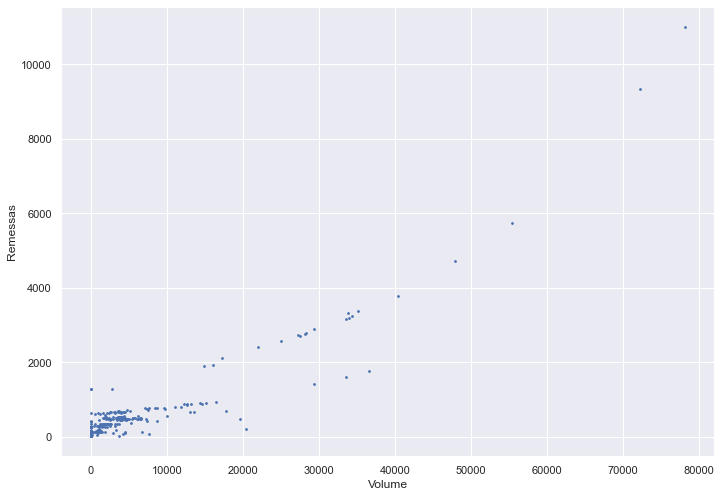

In [ ]:
plt.clf()

plt.scatter(X_val['Volume'], resultadoPoisson, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

Assimetria: 5.936045972054284
Curtose: 45.58368578856809


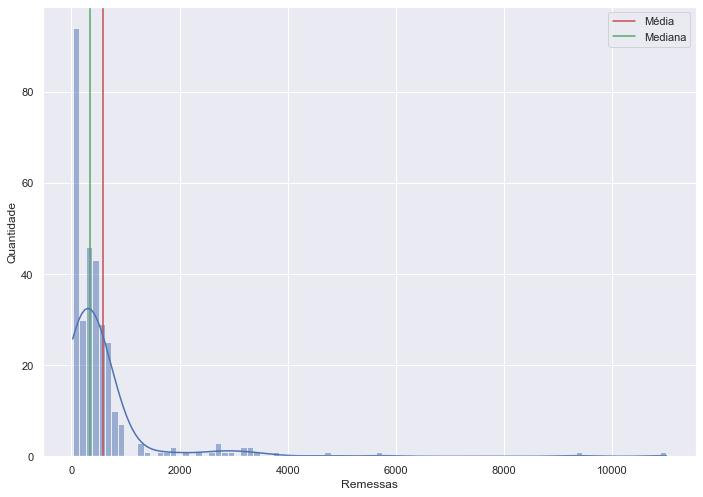

In [ ]:
gerarHistograma(resultadoPoisson)

Parece bom... Mas, o quão bom?

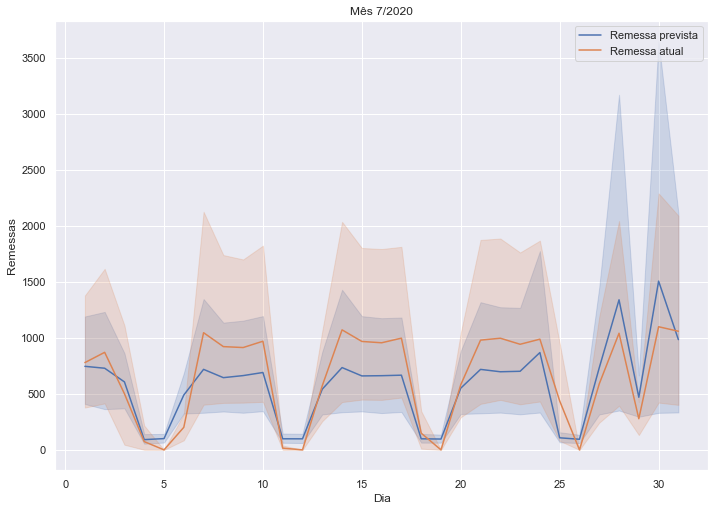

In [ ]:
gerarGraficoMensal(X_treino, X_val, y_val, resultadoPoisson, comecoMes = 0)

<Figure size 842.4x595.44 with 0 Axes>

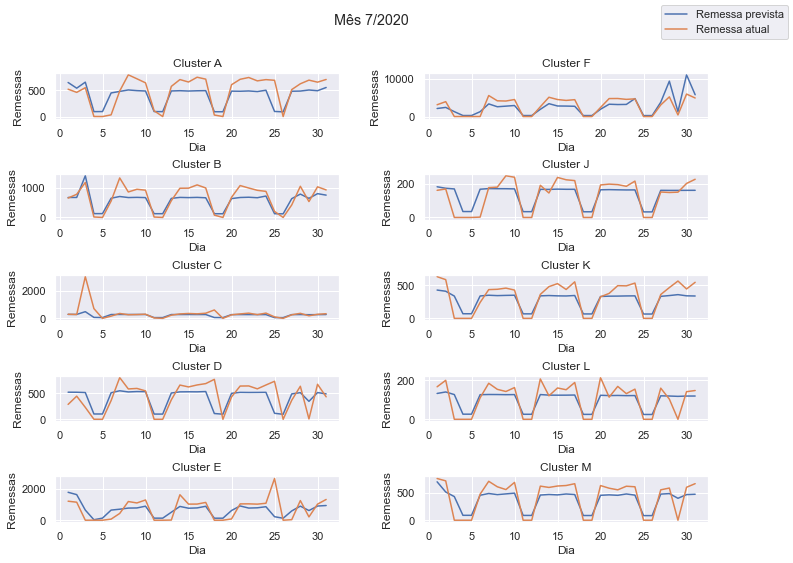

In [ ]:
gerarGraficoMensalClusterEspecifico(X_treino, X_val, y_val, resultadoPoisson, comecoMes = 0)

O gráfico mensal parece se aproximar do valor real, mas será que esse modelo estatístico se saiu melhor que os outros? As métricas podem confirmar ou negar.

In [ ]:
r2Poisson = r2_score(y_val, resultadoPoisson)

r2_val_metrics.append(r2Poisson)

print('R^2 Score: {}'.format(r2Poisson))

R^2 Score: 0.7016045341909544


In [ ]:
gerarMetricaGeral(y_val, resultadoPoisson)

Mean Squared Error: 339551.02302885574
Root Mean Squared Error: 582.7100677256707
Mean Absolute Error: 264.3021794413013



In [ ]:
gerarMetricasClusters(X_val, y_val, resultadoPoisson)

No Cluster A
Mean Squared Error: 42047.39434390873
Root Mean Squared Error: 205.05461307639175
Mean Absolute Error: 168.2954131062544

No Cluster B
Mean Squared Error: 57773.46954661995
Root Mean Squared Error: 240.3611232013612
Mean Absolute Error: 202.18486542825335

No Cluster C
Mean Squared Error: 237708.11732886636
Root Mean Squared Error: 487.55319435818114
Mean Absolute Error: 166.64786874226567

No Cluster D
Mean Squared Error: 46121.98173404921
Root Mean Squared Error: 214.76028900625275
Mean Absolute Error: 160.64211548219717

No Cluster E
Mean Squared Error: 318086.5324374173
Root Mean Squared Error: 563.9916067083067
Mean Absolute Error: 386.9572410273921

No Cluster F
Mean Squared Error: 2641610.68145044
Root Mean Squared Error: 1625.3032583030283
Mean Absolute Error: 1217.2108938363124

No Cluster J
Mean Squared Error: 3286.789397698841
Root Mean Squared Error: 57.33052762445887
Mean Absolute Error: 42.886389431324844

No Cluster K
Mean Squared Error: 18421.71762573322
Ro

Os resultados da distribuição de Poisson não foram muito diferentes obtidos pela Regressão Linear, caindo no mesmo problema: o algoritmo não sabe identificar os zeros e lidar com eles. 

In [ ]:
gerarExcel(resultadoPoisson, X_val, mes = mes, ano = ano, nome = 'Poisson', train = True)

### Distribuição de Poisson com *Zero-Inflated Regressor*

Então, para melhorar o modelo estatístico, o regressor para conjuntos de dados inflados por zeros pode resolver. Como classificador, esse modelo utiliza o *Random Forest* e, para o regressor, a Distribuição de Poisson padrão.

In [ ]:
resultado_ZIR_Poisson = gerarResultadoZIRPoisson(X_treino, X_val, y_treino)

Text(0, 0.5, 'Remessas')

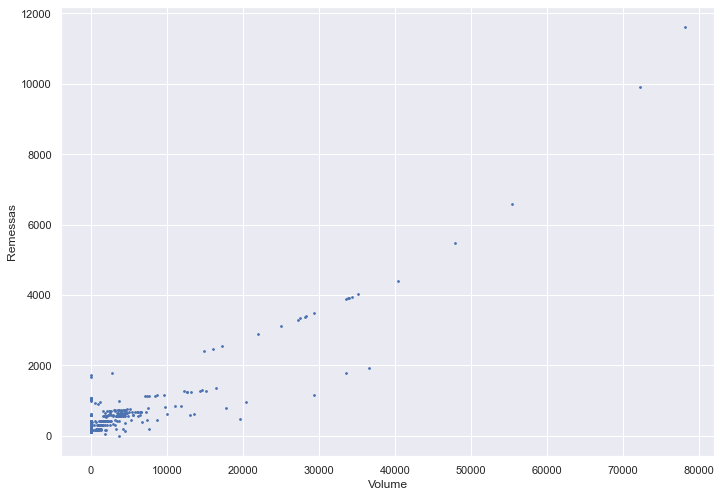

In [ ]:
plt.clf()

plt.scatter(X_val['Volume'], resultado_ZIR_Poisson, s = 3)

plt.xlabel("Volume")
plt.ylabel("Remessas")

Assimetria: 5.345208626270337
Curtose: 37.18044681973491


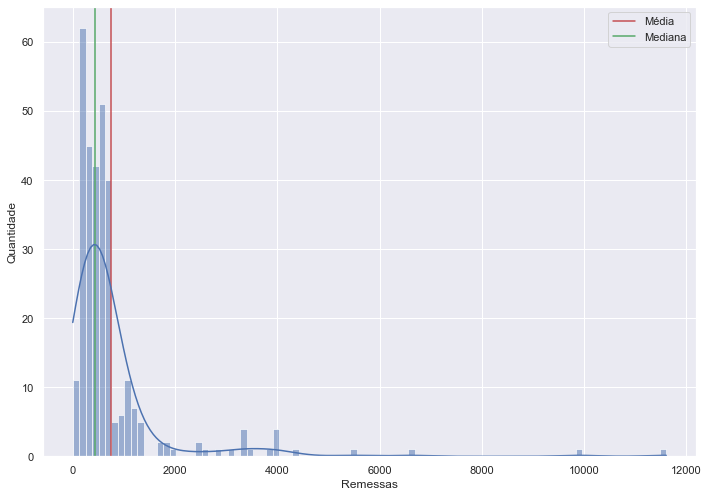

In [ ]:
gerarHistograma(resultado_ZIR_Poisson)

Os valores parecem um pouco melhor distribuidos... E a previsão?

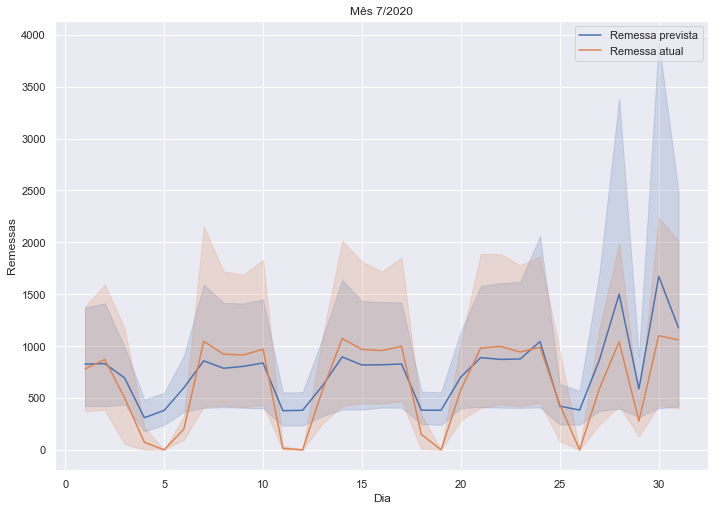

In [ ]:
gerarGraficoMensal(X_treino, X_val, y_val, resultado_ZIR_Poisson, comecoMes = 0)

<Figure size 842.4x595.44 with 0 Axes>

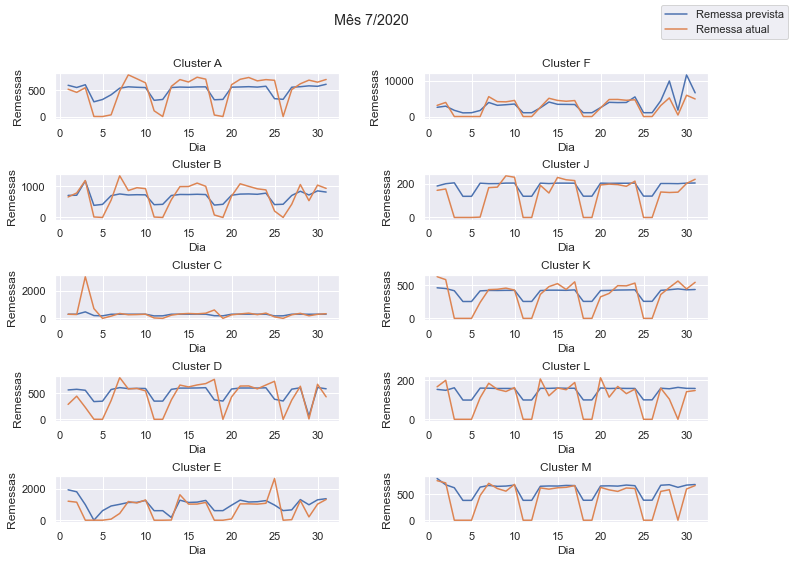

In [ ]:
gerarGraficoMensalClusterEspecifico(X_treino, X_val, y_val, resultado_ZIR_Poisson, comecoMes = 0)

O gráfico parece pior, mas será que houve uma queda nos valores das métricas?

In [ ]:
r2_ZIR_Poisson = r2_score(y_val, resultado_ZIR_Poisson)

r2_val_metrics.append(r2_ZIR_Poisson)

print('R^2 Score: {}'.format(r2_ZIR_Poisson))

R^2 Score: 0.674435243619752


In [ ]:
gerarMetricaGeral(y_val, resultado_ZIR_Poisson)

Mean Squared Error: 370467.5799658289
Root Mean Squared Error: 608.6604800427156
Mean Absolute Error: 290.7517720900606



In [ ]:
gerarMetricasClusters(X_val, y_val, resultado_ZIR_Poisson)

No Cluster A
Mean Squared Error: 39533.45693646082
Root Mean Squared Error: 198.83022138613842
Mean Absolute Error: 167.57020096376735

No Cluster B
Mean Squared Error: 77005.22385694248
Root Mean Squared Error: 277.49815108743064
Mean Absolute Error: 242.91435152847578

No Cluster C
Mean Squared Error: 235437.31056574316
Root Mean Squared Error: 485.2188275054289
Mean Absolute Error: 176.6124728075134

No Cluster D
Mean Squared Error: 47040.10125613882
Root Mean Squared Error: 216.88730081804886
Mean Absolute Error: 170.08826789165698

No Cluster E
Mean Squared Error: 323119.028258096
Root Mean Squared Error: 568.4355972826614
Mean Absolute Error: 430.3844762824989

No Cluster F
Mean Squared Error: 2875126.9401283483
Root Mean Squared Error: 1695.6199279698114
Mean Absolute Error: 1293.551911099679

No Cluster J
Mean Squared Error: 7498.126932508312
Root Mean Squared Error: 86.59172554296578
Mean Absolute Error: 63.72061311845936

No Cluster K
Mean Squared Error: 28122.4386042284
Root

Os valores definitivamente pioraram em comparação à distribuição normal. Valores variando bastante, não tendo constância. O classificador *Random Forest*, nesse caso, não ajudou o regressor a predizer valores.

In [ ]:
gerarExcel(resultado_ZIR_Poisson, X_val, mes = mes, ano = ano, nome = 'ZIR_Poisson', train = True)

## Conclusão

In [ ]:
X_treino, X_teste, y_treino, y_teste = gerarMesTeste(X_treino, y_treino, 8, 2020)

r2_teste_metrics = []

Para a conclusão, será utilizado o conjunto de dados sem o mês de validação para criar o conjunto de treino, e, o último mês (Agosto de 2020) como o teste. No fim, será exibido uma comparação no valor da métrica $R^2$ das fases de validação e teste.

### *Random Forest* convencional

In [ ]:
resultado_teste_RF = gerarResultadoRandomForest(X_treino, X_teste, y_treino)


In [ ]:
r2_RF = r2_score(y_teste, resultado_teste_RF)

r2_teste_metrics.append(r2_RF)

### *Random Forest* com *Zero-Inflated Regressor*

In [ ]:
resultado_teste_ZIR_RF = gerarResultadoZIRRandomForest(X_treino, X_teste, y_treino)

In [ ]:
r2_ZIR_RF = r2_score(y_teste, resultado_teste_ZIR_RF)

r2_teste_metrics.append(r2_ZIR_RF)

### Regressão Linear convencional

In [ ]:
resultado_teste_LR1 = gerarResultadoLinearRegression(X_treino, X_teste, y_treino)

Features utilizadas: ['Volume']


In [ ]:
r2_LR1 = r2_score(y_teste, resultado_teste_LR1)

r2_teste_metrics.append(r2_LR1)

In [ ]:
resultado_teste_LR8 = gerarResultadoLinearRegression(X_treino, X_teste, y_treino, n = 8)

Features utilizadas: ['Volume', 'Dropsize', 'Dia', 'Mês', 'Ano', 'é_dia_normal', 'é_feriado', 'é_fim_de_semana']


In [ ]:
r2_LR8 = r2_score(y_teste, resultado_teste_LR8)

r2_teste_metrics.append(r2_LR8)

In [ ]:
resultado_teste_LR18 = gerarResultadoLinearRegression(X_treino, X_teste, y_treino, n = 18)

Features utilizadas: ['Volume', 'Dropsize', 'Dia', 'Mês', 'Ano', 'é_dia_normal', 'é_feriado', 'é_fim_de_semana', 'Cluster_A', 'Cluster_B', 'Cluster_C', 'Cluster_D', 'Cluster_E', 'Cluster_F', 'Cluster_J', 'Cluster_K', 'Cluster_L', 'Cluster_M']


In [ ]:
r2_LR18 = r2_score(y_teste, resultado_teste_LR18)

r2_teste_metrics.append(r2_LR18)

### Regressão Linear com *Zero-Inflated Regressor*

In [ ]:
resultado_teste_ZIR_LR = gerarResultadoZIR_LR(X_treino, X_teste, y_treino, n = 18)

Features utilizadas: ['Volume', 'Dropsize', 'Dia', 'Mês', 'Ano', 'é_dia_normal', 'é_feriado', 'é_fim_de_semana', 'Cluster_A', 'Cluster_B', 'Cluster_C', 'Cluster_D', 'Cluster_E', 'Cluster_F', 'Cluster_J', 'Cluster_K', 'Cluster_L', 'Cluster_M']


In [ ]:
r2_ZIR_LR = r2_score(y_teste, resultado_teste_ZIR_LR)

r2_teste_metrics.append(r2_ZIR_LR)

### Distribuição de Poisson convencional

In [ ]:
resultado_teste_Poisson = gerarResultadoPoisson(X_treino, X_teste, y_treino)


In [ ]:
r2_Poisson = r2_score(y_teste, resultado_teste_Poisson)

r2_teste_metrics.append(r2_Poisson)

### Distribuição de Poisson com *Zero-Inflated Regressor*

In [ ]:
resultado_teste_ZIR_Poisson = gerarResultadoZIRPoisson(X_treino, X_teste, y_treino)

In [ ]:
r2_ZIR_Poisson = r2_score(y_teste, resultado_teste_ZIR_Poisson)

r2_teste_metrics.append(r2_ZIR_Poisson)

### Gráfico de comparação de métricas na validação e teste

Text(0, 0.5, 'Pontuações R^2 teste')

<Figure size 842.4x595.44 with 0 Axes>

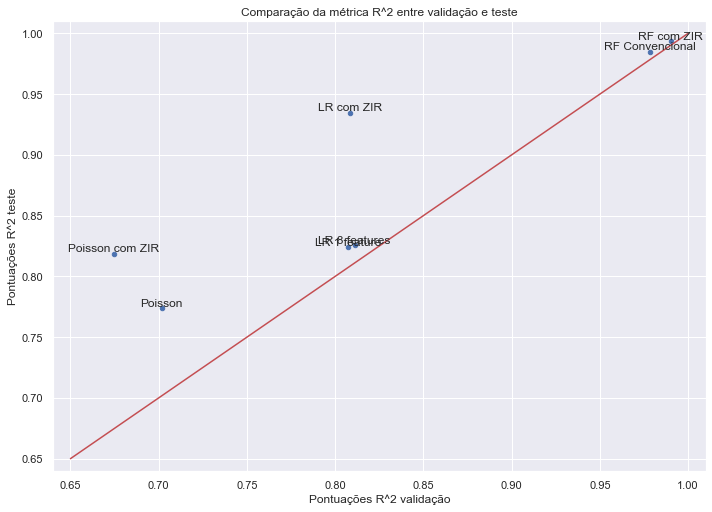

In [ ]:
plt.clf()

line = np.linspace(0.65, 1, 10)

models = ['RF Convencional', 'RF com ZIR', 'LR 1 feature', 'LR 8 features', 'LR todas as features','LR com ZIR', 'Poisson', 'Poisson com ZIR']

fig, ax = plt.subplots()
ax.scatter(r2_val_metrics, r2_teste_metrics, s = 20)
ax.plot(line, line, '-r')

for i, txt in enumerate(models):
    ax.annotate(txt, (r2_val_metrics[i], r2_teste_metrics[i]), ha = 'center', va = 'bottom')

plt.xlim(0.64, 1.01)
plt.ylim(0.64, 1.01)

plt.title("Comparação da métrica R^2 entre validação e teste")

plt.xlabel("Pontuações R^2 validação")
plt.ylabel("Pontuações R^2 teste")

Nesse gráfico, a linha vermelha representa quando as pontuações em ambas as fases de validação e teste. Quanto mais próximo da linha e mais próximo dos eixos x e y = 1, melhor o resultado.

Os algoritmos que se saíram melhor nesse case foi as implementações convencionais de *Random Forest*, com ambas as duas tendo um alto valor na métrica $R^2$ tanto na fase de validação quanto em teste. Os modelos que se saíram relativamente bem foram todas as versões das implementações da regressão linear, tanto utilizando 1, 8, e todas a *features*, além das sua versão inflada por zeros. Essa última se desempenhou de maneira excelente na fase de teste, mas não desempenhou de maneira parecida na fase de validação, tendo uma métrica $R^2$ mais baixa. Já a Distribuição de Poisson e a sua versão inflada por zeros não se saíram bem em comparação aos outros, possivelmente sendo resultado de valores que não variam o suficiente, sendo sua predição somente uma probabilidade de ser um dos outros valores já treinados pelo modelo. 

## Modelos preditivos para o conjunto de dados "Plano de Volume"

Agora, os modelos serão treinados com os dados históricos e, então, gerar um arquivo em Excel com os resultados para o mês de setembro de 2020, utilizando os dados do Excel "Plano de Volume" como entrada para o teste.

In [ ]:
X_treino, X_teste, y_treino = gerarDados(trainTestSplit = True)

### *Random Forest* convencional

In [ ]:
resultadoRF = gerarResultadoRandomForest(X_treino, X_teste, y_treino)

In [ ]:
gerarHistograma(resultadoRF)

In [ ]:
gerarExcel(resultadoRF, X_teste, mes = 9, ano = 2020, nome = '_Outubro_2020_RandomForest')

### *Random Forest* com *Zero-Inflated Regressor*

In [ ]:
resultado_RF_ZIR = gerarResultadoZIRRandomForest(X_treino, X_teste, y_treino)

In [ ]:
gerarHistograma(resultado_RF_ZIR)

In [ ]:
gerarExcel(resultado_RF_ZIR, X_teste, mes = 9, ano = 2020, nome = '_Outubro_2020_ZIR_RandomForest')

### Regressão Linear

In [ ]:
resultadoLR = gerarResultadoLinearRegression(X_treino, X_teste, y_treino, n = 18)

In [ ]:
gerarHistograma(resultadoLR)

In [ ]:
gerarExcel(resultadoLR, X_teste, mes = 9, ano = 2020, nome = '_Outubro_2020_Linear_Regression')

### Regressão Linear com *Zero-Inflated Regressor*

In [ ]:
resultado_ZIR_LR = gerarResultadoZIR_LR(X_treino, X_teste, y_treino, n = 18)

In [ ]:
gerarHistograma(resultado_ZIR_LR)

In [ ]:
gerarExcel(resultado_ZIR_LR, X_teste, mes = 9, ano = 2020, nome = '_Outubro_2020_ZIR_Linear_Regression')

### Distribuição de Poisson

In [ ]:
resultadoPoisson = gerarResultadoPoisson(X_treino, X_teste, y_treino)

In [ ]:
gerarHistograma(resultadoPoisson)

In [ ]:
gerarExcel(resultadoPoisson, X_teste, mes = 9, ano = 2020, nome = '_Outubro_2020_Poisson')

### Distribuição de Poisson com *Zero-Inflated Regressor*

In [ ]:
resultado_Poisson_ZIR = gerarResultadoZIRPoisson(X_treino, X_teste, y_treino)

In [ ]:
gerarHistograma(resultado_Poisson_ZIR)

In [ ]:
gerarExcel(resultado_Poisson_ZIR, X_teste, mes = 9, ano = 2020, nome = '_Outubro_2020_Poisson_ZIR')